In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [44]:
data = pd.read_csv('data/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [45]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [46]:
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [48]:
data.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'], dtype=object)

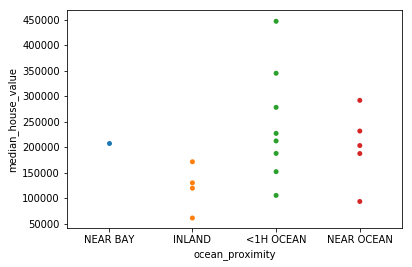

In [49]:
sns.stripplot(x='ocean_proximity',y='median_house_value',data=data[data['total_rooms']==1527.0])

## Normalizing Data

In [122]:
#Normalizing Features
data['room_per_household'] = data.total_rooms/data.households
data['bedroom_per_household'] = data.total_bedrooms/data.households
data['household_pop'] = data.population/data.households

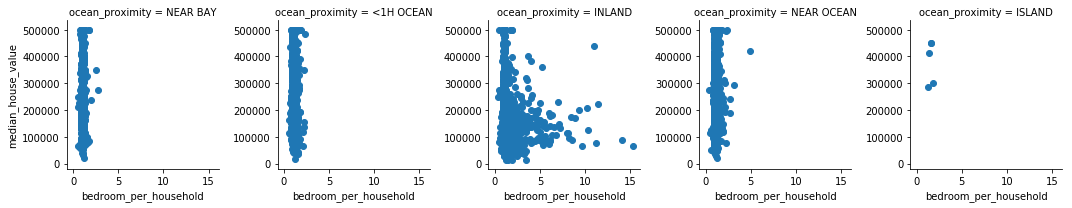

In [17]:
d = data[data.bedroom_per_household<20]
g = sns.FacetGrid(data=d,col='ocean_proximity')
g.map(plt.scatter,'bedroom_per_household','median_house_value')

### Missing Values

In [50]:
# Fill Nan
data.total_bedrooms.fillna(data.total_bedrooms.median(), inplace=True)

In [37]:
data.total_bedrooms.isnull().sum()

0

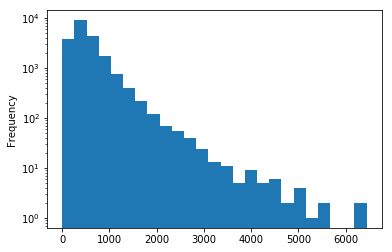

In [24]:
data.total_bedrooms.plot(kind='hist', bins=25, log=True)

## Random Forest (no normalization)

In [58]:
X = data[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
              'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']]
X = pd.get_dummies(data=X, columns=['ocean_proximity'])
y = data['median_house_value']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    shuffle=True, random_state=73)

In [65]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=500, max_depth=3, max_features=3, n_jobs=-1, random_state=73)
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=73,
           verbose=0, warm_start=False)

longitude                     0.073087
latitude                      0.085055
housing_median_age            0.021141
total_rooms                   0.027784
total_bedrooms                0.003357
population                    0.009466
households                    0.004144
median_income                 0.410802
ocean_proximity_<1H OCEAN     0.065284
ocean_proximity_INLAND        0.266248
ocean_proximity_ISLAND        0.000023
ocean_proximity_NEAR BAY      0.017318
ocean_proximity_NEAR OCEAN    0.016292
dtype: float64


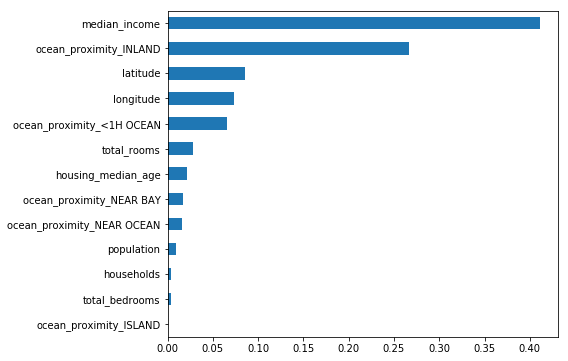

In [74]:
feature_importances = pd.Series(rfr.feature_importances_, index=X_train.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

In [84]:
rfr.score(X_train, y_train)

0.49285428472430565

In [86]:
rfr.score(X_test, y_test)

0.49111420496525915

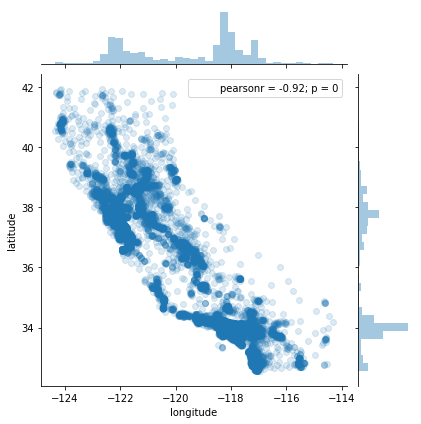

In [87]:
sns.jointplot(data.longitude, data.latitude, alpha=.15)

#### Grid Search

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor()

parameters = {'max_depth': range(3,8), 'max_features': range(2,7)}
grid_search = GridSearchCV(estimator=rf_regr, param_grid=parameters, cv=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 8), 'max_features': range(2, 7)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [117]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.719
Best parameters set:
	max_depth: 7
	max_features: 6


In [118]:
from sklearn.ensemble import RandomForestRegressor

rfr2 = RandomForestRegressor(n_estimators=750, max_depth=7, max_features=6, n_jobs=-1, random_state=73)
rfr2.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=750, n_jobs=-1, oob_score=False, random_state=73,
           verbose=0, warm_start=False)

longitude                     0.073087
latitude                      0.085055
housing_median_age            0.021141
total_rooms                   0.027784
total_bedrooms                0.003357
population                    0.009466
households                    0.004144
median_income                 0.410802
ocean_proximity_<1H OCEAN     0.065284
ocean_proximity_INLAND        0.266248
ocean_proximity_ISLAND        0.000023
ocean_proximity_NEAR BAY      0.017318
ocean_proximity_NEAR OCEAN    0.016292
dtype: float64


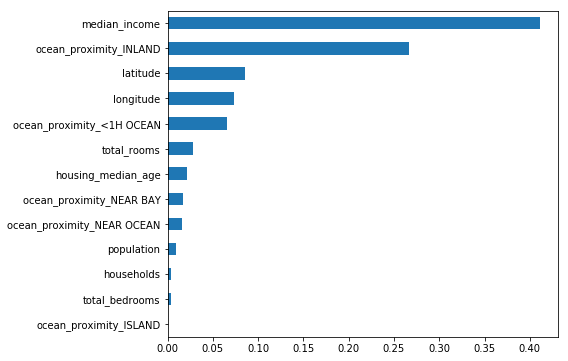

In [119]:
feature_importances = pd.Series(rfr.feature_importances_, index=X_train.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

In [120]:
rfr2.score(X_train, y_train)

0.75970359531183684

In [121]:
rfr2.score(X_test, y_test)

0.73721359416251953

## Random Forest (with normalization)

In [123]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'room_per_household',
       'bedroom_per_household', 'household_pop'],
      dtype='object')

In [124]:
X = data[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'room_per_household',
       'bedroom_per_household', 'household_pop']]
X = pd.get_dummies(data=X, columns=['ocean_proximity'])
y = data['median_house_value']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    shuffle=True, random_state=73)

#### Grid Search

In [125]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor()

parameters = {'max_depth': range(3,8), 'max_features': range(2,7)}
grid_search = GridSearchCV(estimator=rf_regr, param_grid=parameters, cv=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 8), 'max_features': range(2, 7)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [126]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.985
Best parameters set:
	max_depth: 7
	max_features: 6


In [127]:
from sklearn.ensemble import RandomForestRegressor

rfr2 = RandomForestRegressor(n_estimators=750, max_depth=7, max_features=6, n_jobs=-1, random_state=73)
rfr2.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=750, n_jobs=-1, oob_score=False, random_state=73,
           verbose=0, warm_start=False)

longitude                     0.010423
latitude                      0.011204
housing_median_age            0.004635
total_rooms                   0.001584
total_bedrooms                0.000714
population                    0.001205
households                    0.000804
median_income                 0.154108
median_house_value            0.668415
room_per_household            0.028409
bedroom_per_household         0.001766
household_pop                 0.020646
ocean_proximity_<1H OCEAN     0.008819
ocean_proximity_INLAND        0.085644
ocean_proximity_ISLAND        0.000009
ocean_proximity_NEAR BAY      0.000758
ocean_proximity_NEAR OCEAN    0.000860
dtype: float64


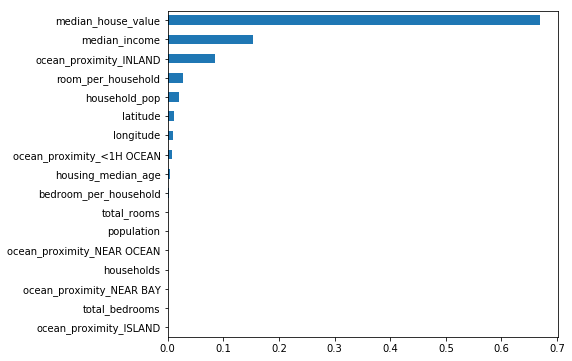

In [130]:
feature_importances = pd.Series(rfr2.feature_importances_, index=X_train.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

In [131]:
rfr2.score(X_train, y_train)

0.99103938529416125

In [132]:
rfr2.score(X_test, y_test)

0.98911763543743703

## Random Forest (with normalization - excluding features)

In [133]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'room_per_household',
       'bedroom_per_household', 'household_pop'],
      dtype='object')

In [134]:
X = data[['longitude', 'latitude', 'housing_median_age',
       'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'room_per_household',
       'bedroom_per_household', 'household_pop']]
X = pd.get_dummies(data=X, columns=['ocean_proximity'])
y = data['median_house_value']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    shuffle=True, random_state=73)

#### Grid Search

In [135]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor()

parameters = {'max_depth': range(3,8), 'max_features': range(2,7)}
grid_search = GridSearchCV(estimator=rf_regr, param_grid=parameters, cv=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 8), 'max_features': range(2, 7)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [136]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.989
Best parameters set:
	max_depth: 7
	max_features: 6


In [137]:
from sklearn.ensemble import RandomForestRegressor

rfr2 = RandomForestRegressor(n_estimators=750, max_depth=7, max_features=6, n_jobs=-1, random_state=73)
rfr2.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=750, n_jobs=-1, oob_score=False, random_state=73,
           verbose=0, warm_start=False)

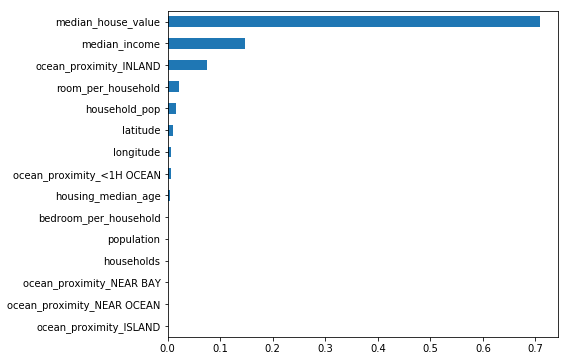

In [138]:
feature_importances = pd.Series(rfr2.feature_importances_, index=X_train.columns)
#print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

In [139]:
rfr2.score(X_train, y_train)

0.99461149698350826

In [140]:
rfr2.score(X_test, y_test)

0.99330516573469818